In [1]:
import numpy as np
import pandas as pd
import time
import datetime
from pathlib import Path
import os
import gc
import random
import nltk
import itertools
from nltk.corpus import stopwords
from typing import Literal, Callable
import re
from torch.utils.data import Dataset
from functools import partial

import torch
from torch import Tensor
import torch.nn as nn
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
    random_split,
)
import torch.nn.functional as F
from torch.optim import Adam
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import (
    BertForSequenceClassification,
    AdamW,
    BertConfig,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)
from torch.utils.data import WeightedRandomSampler

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassConfusionMatrix,
)

from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

In [2]:
Path_t = str | bytes | os.PathLike

In [3]:
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)

Global seed set to 123


123

In [4]:
device = torch.device("cuda")
torch.set_float32_matmul_precision("high")

In [5]:
TRAIN_PATH = Path("./data/train_data.csv")
NLTK_DIR = Path("./nltk")
MODEL_DIR = Path("./models")

In [6]:
nltk.download("stopwords", download_dir=NLTK_DIR)

[nltk_data] Downloading package stopwords to nltk...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
torch.nn.CrossEntropyLoss()

CrossEntropyLoss()

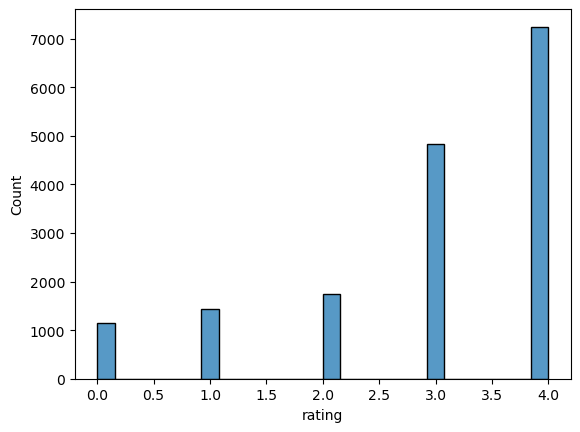

In [8]:
df_raw = pd.read_csv(TRAIN_PATH)
sns.histplot(df_raw["rating"])
cls_counts = np.histogram(df_raw["rating"], bins=5)[0]

In [9]:
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS


class TextClassificationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_path: Path_t,
        tokenizer: BertTokenizer,
        batch_size: int,
        val_fraction: float = 0.0,
        truncation_strategy: Literal["truncate"] = "truncate",
        max_seq_len: int = 512,
        clean_fn: Callable[[str], str] = lambda x: x,
        n_first: int | None = None  # just for testing purposes
    ):
        super(TextClassificationDataModule, self).__init__()
        assert 0 <= val_fraction <= 1

        self._data_path = data_path
        self._clean_fn = clean_fn
        self._tokenizer = tokenizer
        self._encode_fn = partial(
            tokenizer.encode_plus,
            add_special_tokens=True,
            max_length=max_seq_len,
            truncation=True if truncation_strategy == "truncate" else False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        self.val_fraction = val_fraction
        self.batch_size = batch_size
        
        self._n_first = n_first

        self._encoded: list[dict[str, Tensor]]
        self._train: Dataset
        self._val: Dataset
        self._test: Dataset

    def setup(self, stage: Literal["fit", "test"]) -> None:
        if stage == "fit":
            df_raw = pd.read_csv(self._data_path)
            ratings = df_raw["rating"].values[:self._n_first]
            dataset = TensorDataset(
                *(
                    torch.cat([item[k] for item in self._encoded], dim=0)
                    for k in ("input_ids", "attention_mask")
                ),
                torch.tensor(ratings),
            )
            val_size = int(len(dataset) * self.val_fraction)
            train_size = len(dataset) - val_size

            self._train, self._val = torch.utils.data.random_split(
                dataset, [train_size, val_size]
            )

        if stage == "test":
            self._test = TensorDataset(
                *(
                    torch.cat([item[k] for item in self._encoded], dim=0)
                    for k in ("input_ids", "attention_mask")
                )
            )

    def prepare_data(self) -> None:
        df_raw = pd.read_csv(self._data_path)
        reviews = df_raw["review"].apply(self._clean_fn).values[:self._n_first]
        self._encoded = [self._encode_fn(review) for review in reviews]

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            # self._train, batch_size=self.batch_size, pin_memory=True, sampler=WeightedRandomSampler(weights=1/cls_counts, num_samples=len(self._train), replacement=True)
            self._train, batch_size=self.batch_size, shuffle=True, pin_memory=True
        )

    def val_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self._val, batch_size=self.batch_size, shuffle=False, pin_memory=True
        )

    def test_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self._test, batch_size=self.batch_size, shuffle=False, pin_memory=True
        )

In [10]:
from typing import Any


class BertRegressorClassifier(pl.LightningModule):
    def __init__(
        self,
        model: BertForSequenceClassification,
        num_classes: int,
        lr: float,
        weight_decay: float = 0.0,
        warmup_steps: int = 0,
        freeze_encoder: bool = False,
    ):
        super(BertRegressorClassifier, self).__init__()
        assert model.num_labels == 1
        self.num_classes = num_classes

        self.model = model
        self._lr = lr
        self._weight_decay = weight_decay
        self._warmup_steps = warmup_steps
        self._freeze_encoder = freeze_encoder

        if freeze_encoder:
            for param in self.model.base_model.parameters():
                param.requires_grad = False

        self.save_hyperparameters(ignore=["model"])
        
        self.reg_metrics = {
            "mse": MeanSquaredError().to(device),
            "mae": MeanAbsoluteError().to(device),
        }

        self.flat_metrics = {
            "accuracy": MulticlassAccuracy(num_classes=num_classes, average="micro").to(device),
            "precision": MulticlassPrecision(num_classes=num_classes, average="micro").to(device),
            "recall": MulticlassRecall(num_classes=num_classes, average="micro").to(device),
            "f1": MulticlassF1Score(num_classes=num_classes, average="micro").to(device),
        }
        self.class_metrics = {
            "accuracy": MulticlassAccuracy(num_classes=num_classes, average="none").to(device),
            "precision": MulticlassPrecision(num_classes=num_classes, average="none").to(device),
            "recall": MulticlassRecall(num_classes=num_classes, average="none").to(device),
            "f1": MulticlassF1Score(num_classes=num_classes, average="none").to(device),
        }
        self.confusion_matrix = MulticlassConfusionMatrix(
            num_classes=num_classes, normalize="pred"
        ).to(device)

    def configure_optimizers(self) -> Any:
        self.trainer.fit_loop.setup_data()
        total_devices = getattr(self.hparams, "n_gpus", 1) * getattr(self.hparams, "n_nodes", 1)
        train_batches = len(self.trainer.train_dataloader) // total_devices
        train_steps = (
            self.trainer.max_epochs * train_batches
        ) // self.trainer.accumulate_grad_batches
        # will not work with AdamW (plus it is deprecated anyway)
        # https://discuss.huggingface.co/t/runtimeerror-element-0-of-tensors-does-not-require-grad-and-does-not-have-a-grad-fn/47965/2
        optimizer = Adam(self.model.parameters(), lr=self._lr, eps=1e-8, weight_decay=self._weight_decay)
        lr_scheduler = get_linear_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=self._warmup_steps,
            num_training_steps=train_steps,
        )
        return [optimizer], [lr_scheduler]

    def training_step(
        self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int
    ) -> dict[str, Tensor]:
        input_ids, input_mask, labels = batch
        output = self.model(
            input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels.to(torch.float)
        )
        loss = output.loss

        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor, Tensor], batch_idx: int
    ) -> dict[str, Tensor]:
        with torch.no_grad():
            input_ids, input_mask, labels = batch
            output = self.model(
                input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels.to(torch.float)
            )
            loss = output.loss

            preds = output.logits.squeeze()
            self.log("val_loss", loss, prog_bar=True)
            self.log_dict(
                {name: metric(preds, labels) for name, metric in self.reg_metrics.items()},
                prog_bar=True,
            )
            preds = preds.round().clamp(0, self.num_classes-1)
            self.log_dict(
                {name: metric(preds, labels) for name, metric in self.flat_metrics.items()},
                prog_bar=True,
            )
            self.log_dict(
                {
                    f"{name}_{c}": v
                    for name, metric_values in {
                        _name: metric(preds, labels)
                        for _name, metric in self.class_metrics.items()
                    }.items()
                    for c, v in enumerate(metric_values)
                },
                prog_bar=True,
            )
            self.confusion_matrix(preds, labels)

    def on_validation_epoch_end(self) -> None:
        with torch.no_grad():
            confusion_matrix = self.confusion_matrix.compute()

            df_cm = pd.DataFrame(
                confusion_matrix.cpu().numpy(), index=range(5), columns=range(5)
            )
            fig, ax = plt.subplots(figsize=(10, 7))
            sns.heatmap(
                df_cm,
                ax=ax,
                annot=True,
                cmap="Greens",
                vmin=0,
                vmax=1,
                annot_kws={"size": 6},
                fmt=".3f",
                
            )
            ax.set_xlabel("True class")
            ax.set_ylabel("Predicted class")
            self.logger.experiment.add_figure("Confusion matrix", fig, self.current_epoch)

    def predict_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> Any:
        with torch.no_grad():
            input_ids, input_mask, labels = batch
            return self.model(
                input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels
            )

In [11]:
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-small", do_lower_case=True, cache_dir=MODEL_DIR)

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
nltk.download('stopwords', download_dir=NLTK_DIR)
sw = stopwords.words('english')

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = " ".join(text)
    return text

[nltk_data] Downloading package stopwords to nltk...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
dm = TextClassificationDataModule(
    data_path=Path(TRAIN_PATH),
    tokenizer=tokenizer,
    val_fraction=0.2,
    batch_size=128,  # 12 for large model on 24GB
    clean_fn=clean_text,
    max_seq_len=512
)
dm.prepare_data()
dm.setup("fit")

In [14]:
model = BertRegressorClassifier(
    model=BertForSequenceClassification.from_pretrained(
        "prajjwal1/bert-small",
        # "bert-base-uncased",
        # "nlptown/bert-base-multilingual-uncased-sentiment",
        # "bert-large-uncased",
        num_labels=1,
        output_attentions=False,
        output_hidden_states=False,
        cache_dir=MODEL_DIR
    ),
    num_classes=5,
    lr=5e-5,
    weight_decay=1e-3,
    warmup_steps=0,
    freeze_encoder=False,
)
model

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertRegressorClassifier(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 512, padding_idx=0)
        (position_embeddings): Embedding(512, 512)
        (token_type_embeddings): Embedding(2, 512)
        (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-3): 4 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=512, out_features=512, bias=True)
                (key): Linear(in_features=512, out_features=512, bias=True)
                (value): Linear(in_features=512, out_features=512, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=512, out_featur

In [15]:
trainer = pl.Trainer(
    max_epochs=10,
    gradient_clip_val=1,
    callbacks=[RichProgressBar()],
    precision="bf16-mixed",
    val_check_interval=0.25
)
trainer.fit(model, datamodule=dm)


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model            │ BertForSequenceClassification │ 28.8 M │
│ 1 │ confusion_matrix │ MulticlassConfusionMatrix     │      0 │
└───┴──────────────────┴───────────────────────────────┴────────┘

Trainable params: 28.8 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 28.8 M                                                                                               
Total estimated model params size (MB): 115

Output()

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
15 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
5 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning:
Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

: 